Wasserstein GAN with Gradient Penalty (WGAN-GP) for Anime Faces in Google Colab


In [ ]:
# Install required packages
!pip install torch torchvision pillow matplotlib tqdm kaggle

In [ ]:
#Import libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
torch.manual_seed(0)  # For reproducibility

In [ ]:
# Set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Upload Kaggle API key
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umair851","key":"8a4f08c2444ada5929398896e9a963f2"}'}

In [ ]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

# Download Anime Face dataset from Kaggle
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip -d animefacedataset
dataset_dir = '/content/animefacedataset/images'

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 99% 392M/395M [00:18<00:00, 24.4MB/s]
100% 395M/395M [00:18<00:00, 22.0MB/s]


In [ ]:
# Visualization function
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

In [ ]:
# Custom Dataset for Anime Faces
class AnimeFaceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=128, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, kernel_size=4, stride=1, padding=0),  # 4x4
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),  # 64x64
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [ ]:
def get_noise(n_samples, z_dim, device=device):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
# Critic
class Critic(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            self.make_crit_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            self.make_crit_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            self.make_crit_block(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),  # 4x4
            self.make_crit_block(hidden_dim * 8, 1, kernel_size=4, stride=1, padding=0, final_layer=True),  # 1x1
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

In [ ]:
# Gradient Penalty Functions
def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Loss Functions
def get_gen_loss(crit_fake_pred):
    return -crit_fake_pred.mean()

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    return crit_fake_pred.mean() - crit_real_pred.mean() + c_lambda * gp

In [ ]:
# Training Initializations
n_epochs = 50
z_dim = 128
display_step = 500
batch_size = 32
lr_gen = 0.0002
lr_crit = 0.0001
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 50
crit_repeats = 3
resume_training = False  # Set to True to resume, False to start fresh

# Data transformation and loading
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = AnimeFaceDataset(img_dir=dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Paths for saving models
base_path = '/content/drive/MyDrive/wgan_gp_anime'
os.makedirs(base_path, exist_ok=True)
gen_path = os.path.join(base_path, 'generator_epoch_{}.pth')
crit_path = os.path.join(base_path, 'critic_epoch_{}.pth')
opt_path = os.path.join(base_path, 'optimizers_epoch_{}.pth')

# Initialize models and optimizers
gen = Generator(z_dim=z_dim, im_chan=3).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta_1, beta_2))
crit = Critic(im_chan=3).to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr_crit, betas=(beta_1, beta_2))

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

Starting training from scratch


  0%|          | 0/1987 [00:00<?, ?it/s]

Step 0, Gradient Penalty: 0.7140066623687744
Step 0, Gradient Penalty: 0.6636045575141907
Step 0, Gradient Penalty: 0.5458528399467468
Step 500, Gradient Penalty: 0.012821762822568417
Step 500, Gradient Penalty: 0.011734582483768463
Step 500, Gradient Penalty: 0.03997809812426567
Epoch 0, Step 500: Generator loss: 2.5684, Critic loss: -3.6730


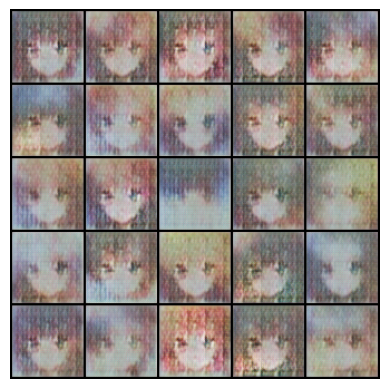

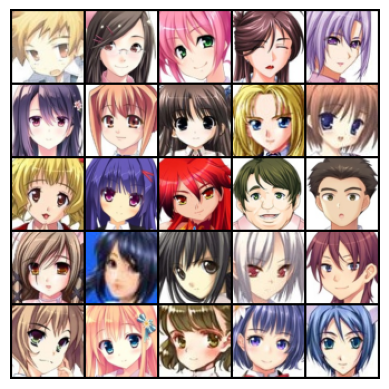

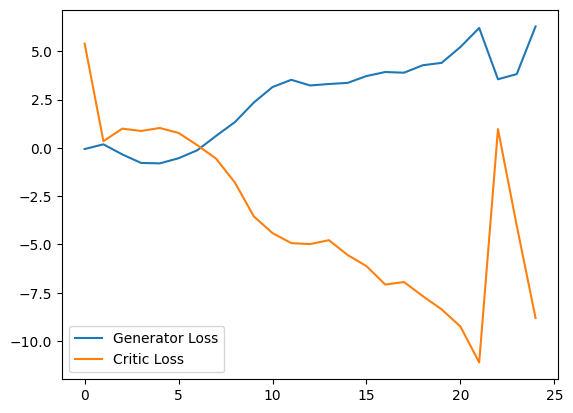

Step 1000, Gradient Penalty: 0.016950009390711784
Step 1000, Gradient Penalty: 0.0022093241568654776
Step 1000, Gradient Penalty: 0.012908000499010086
Epoch 0, Step 1000: Generator loss: 18.5771, Critic loss: -4.4076


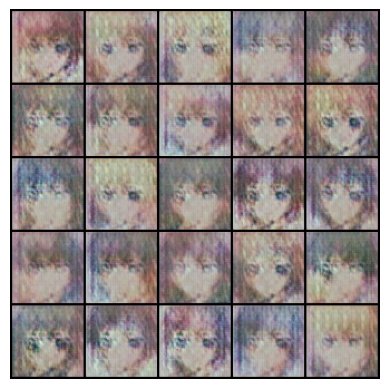

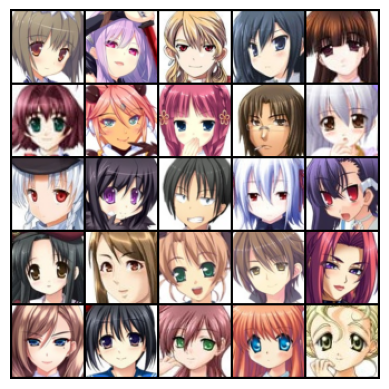

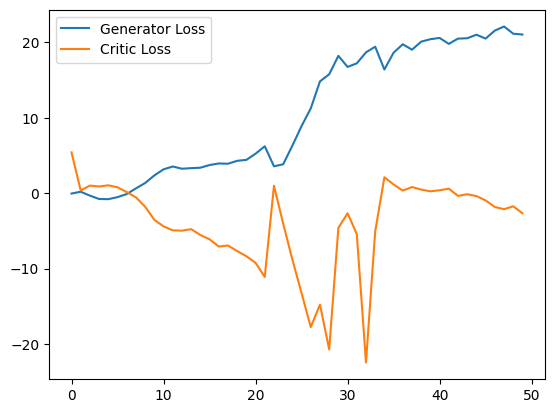

Step 1500, Gradient Penalty: 0.0025606034323573112
Step 1500, Gradient Penalty: 0.0025787013582885265
Step 1500, Gradient Penalty: 0.004797188565135002
Epoch 0, Step 1500: Generator loss: 26.4421, Critic loss: -11.1543


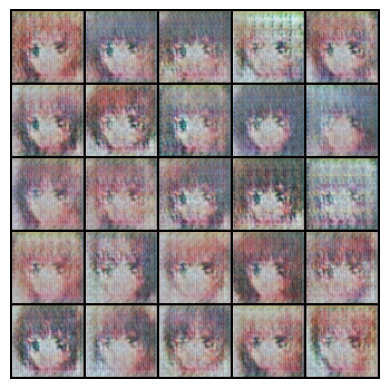

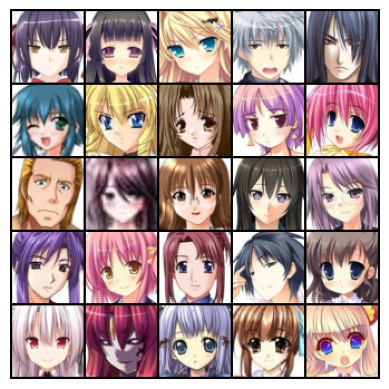

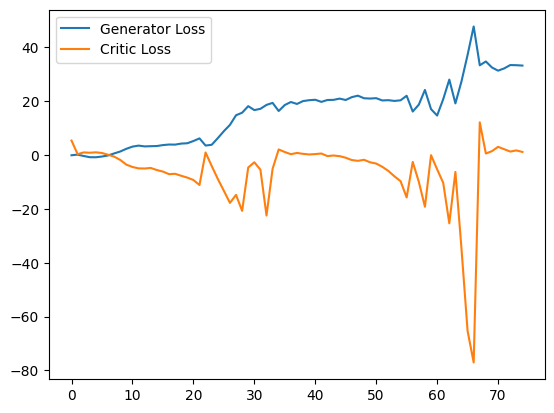

In [ ]:
# Resume training logic based on resume_training flag
start_epoch = 0
if resume_training:
    for epoch in range(n_epochs - 1, -1, -1):
        gen_file = gen_path.format(epoch)
        crit_file = crit_path.format(epoch)
        opt_file = opt_path.format(epoch)
        if os.path.exists(gen_file) and os.path.exists(crit_file) and os.path.exists(opt_file):
            print(f"Resuming from epoch {epoch + 1}")
            gen.load_state_dict(torch.load(gen_file))
            crit.load_state_dict(torch.load(crit_file))
            checkpoint = torch.load(opt_file)
            gen_opt.load_state_dict(checkpoint['gen_opt'])
            crit_opt.load_state_dict(checkpoint['crit_opt'])
            start_epoch = epoch + 1
            break
    if start_epoch == 0:
        print("No saved models found; starting from scratch despite resume_training=True")
        gen = gen.apply(weights_init)
        crit = crit.apply(weights_init)
else:
    print("Starting training from scratch")
    gen = gen.apply(weights_init)
    crit = crit.apply(weights_init)

# Training Loop
cur_step = 0
generator_losses = []
critic_losses = []

for epoch in range(start_epoch, n_epochs):
    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            if cur_step % display_step == 0:
                print(f"Step {cur_step}, Gradient Penalty: {gp.item()}")
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses.append(mean_iteration_critic_loss)

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        generator_losses.append(gen_loss.item())

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, Step {cur_step}: Generator loss: {gen_mean:.4f}, Critic loss: {crit_mean:.4f}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1).cpu(),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1).cpu(),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

    # Save models at the end of each epoch
    torch.save(gen.state_dict(), gen_path.format(epoch))
    torch.save(crit.state_dict(), crit_path.format(epoch))
    torch.save({
        'gen_opt': gen_opt.state_dict(),
        'crit_opt': crit_opt.state_dict()
    }, opt_path.format(epoch))
    print(f"Saved models for epoch {epoch} to Google Drive")

# Final save
torch.save(gen.state_dict(), os.path.join(base_path, 'generator_final.pth'))
torch.save(crit.state_dict(), os.path.join(base_path, 'critic_final.pth'))
torch.save({
    'gen_opt': gen_opt.state_dict(),
    'crit_opt': crit_opt.state_dict()
}, os.path.join(base_path, 'optimizers_final.pth'))
print("Training completed and final models saved")

In [ ]:
# Save models to Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')
torch.save(gen.state_dict(), '/content/drive/MyDrive/generator_anime.pth')
torch.save(crit.state_dict(), '/content/drive/MyDrive/critic_anime.pth')